# Description

This notebook implements the AE LSTM model. All the code was written by our Deep Learning project team. 
Additional external code is imported. You will first find the tool functions for generating the 
data and building the models. Then, at the bottom of the notebook you will find the experiments with 
plots and results used in our repport. 

You can find the customized loss functions in the `Tool Functions` part of the code below. They are called 
`reconstruction_loss_with_sequence_loss` and `reconstruction_loss_without_sequence_loss` respectively for the loss over the entire sequence of LSTM output graphs and the loss over the final output graph only. 

# Imports

In [1]:
## Network Processing
import networkx as nx 
from barabasi_albert import barabasi_albert_graph

## Matrix Processing
import numpy as np
import pandas as pd
import scipy as sp

## AE
import keras.backend as K
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Lambda, LSTM, \
                Conv1DTranspose, Conv2DTranspose, Permute, Bidirectional
from multi_graph_cnn_layer import MultiGraphCNN
import tensorflow as tf

## Data Processing
from sklearn.utils import shuffle

## External tool functions
from utils import *

## Error metrics
from sklearn.metrics import mean_squared_error, r2_score

## Seed the pseudorandom number generator
from random import seed
from random import randint

## Plotting 
import matplotlib.pyplot as plt

# TOOL FUNCTIONS

### Data Generation

In [2]:
def generate_barabasi_adj_matrix(n, m, alpha=1):
    """Generates a Barabasi Alert graph and returns an adjacency matrix with
     a node ordering defined by the networkx Graph library"""
    
    assert n <= N_MAX, 'n must be less or equal that N_MAX'
    
    adj_matrix = np.zeros((N_MAX, N_MAX))
        
    networkx_graph = barabasi_albert_graph(n, m, alpha, seed=SEED)
    sparse_matrix = nx.linalg.graphmatrix.adjacency_matrix(networkx_graph, nodelist=None, weight=None)
    
    adj_matrix[:n, :n] = sparse_matrix.todense()
    
    return adj_matrix

In [3]:
def generate_multi_barabasi_graphs(nb_graphs, scenario_type):
    """Generates 'nb_graphs' Barabasi graphs. Each graph has 'n' nodes, the first 
    parameter of the Barabasi-Albert model, where 'n' is selected in a different way depending 
    of the 'scenario_type', as well as 'm' and 'alpha'.
    The function outputs the adjacency matrices, the feature matrices (identity matrices) 
    and the parameters n and m used in the data generation process"""

    # Each matrix generated during the graph generation process is vertically concatenated to the output
    adjacency_matrices = np.zeros((nb_graphs*N_MAX, N_MAX))
    feature_matrices = np.zeros((nb_graphs*N_MAX, N_MAX))
    parameter_vectors = np.zeros((nb_graphs, LATENT_SPACE_SIZE))

    for sample_graph_index in range(nb_graphs):
        
        if scenario_type == 0:
            # n is constant, m is constant and alpha = 1
            n = N_MIN
            m = N_MIN-1
            alpha = 1
            
        if scenario_type == 1:
            # n is constant, m varies and alpha = 1
            n = N_MAX
            m = randint(1, n-1)
            alpha = 1
            
        if scenario_type == 2:
            # n varies, m is proportional to n and alpha = 1
            n = randint(N_MIN, N_MAX)
            m = max(1, int(n / 3.0))
            alpha = 1
            
        if scenario_type == 3:
            # n varies, m varies and alpha = 1
            n = randint(N_MIN, N_MAX)
            m = randint(1, n-1)
            alpha = 1
            
        if scenario_type == 4:
            # n varies, m varies and alpha varies in [0,1]
            n = randint(N_MIN, N_MAX)
            m = randint(1, n-1)
            alpha = np.random.uniform()
        
        # Generate Barabasi Graph adjacency matrix
        adj_matrix = generate_barabasi_adj_matrix(n, m, alpha)

        # Update output matrices
        row_start_index = N_MAX * sample_graph_index
        
        adjacency_matrices[row_start_index: row_start_index + N_MAX, :] = adj_matrix
        feature_matrices[row_start_index: row_start_index + n, :n] = np.eye(n)
        parameter_vectors[sample_graph_index, :] = [n, m, alpha]
    
    return adjacency_matrices, feature_matrices, parameter_vectors

In [4]:
def format_data(A, X, Y):
    """
    Format the data such that it is a matrix of matrices (a batch containing sample matrices)
    """

    # Load and prepare the adjacency matrices
    num_graph_nodes = A.shape[1]
    num_graphs = int(A.shape[0]/A.shape[1])

    A = np.split(A, num_graphs, axis=0)
    A = np.array(A)

    # Load and prepare the feature matrices
    X = np.split(X, num_graphs, axis=0)
    X = np.array(X)

    # Shuffle data before training
    A, X, Y = shuffle(A, X, Y)
    
    return A, X, Y 

### AE LSTM

In [5]:
def get_mask(step):
    """
    Tool function used in the customized loss. Create a mask that select a specific step of the 
    output sequence of graphs in the LSTM. 
    """
        
    if step > 0: 
          
        mask_zeros_before = tf.fill([BATCH_SIZE_AE, step, N_MAX, N_MAX], 0.0)
        mask_ones = tf.fill([BATCH_SIZE_AE, 1, N_MAX, N_MAX], 1.0)
        mask_zeros_after = tf.fill([BATCH_SIZE_AE, N_MAX-step-1, N_MAX, N_MAX], 0.0)
        
        mask = tf.concat([mask_zeros_before, mask_ones, mask_zeros_after], axis=1)
    
    else:
        
        mask_ones = tf.fill([BATCH_SIZE_AE, 1, N_MAX, N_MAX], 1.0)
        mask_zeros_after = tf.fill([BATCH_SIZE_AE, N_MAX-1, N_MAX, N_MAX], 0.0)
        mask = tf.concat([mask_ones, mask_zeros_after], axis=1)
        
    return mask

In [6]:
def reconstruction_loss_with_sequence_loss(y_true, y_pred):
    """
    Customized reconstruction loss. It ensures that the output sequence of the LSTM corresponds to 
    valid adjacency matrices (symmetric, trace equals 0) and that the first graph is empty, the last 
    graph has similar propreties as the input graph (same number of nodes, number of edges, 
    degree distribution) and the graphs in between have increasing number of nodes and edges.
    """
        
    y_pred = K.reshape(y_pred, shape = (BATCH_SIZE_AE, N_MAX, N_MAX, N_MAX))   
    reconstruction_loss = tf.fill([BATCH_SIZE_AE, N_MAX], 0.0)
             
    ## Loss all steps
     
    # Ensures symmetry  
    t_transpose = tf.transpose(y_pred, perm=[0, 1, 3, 2])
    non_symmetry_loss = y_pred - t_transpose
    non_symmetry_loss = non_symmetry_loss * non_symmetry_loss
    non_symmetry_loss = tf.math.reduce_sum(non_symmetry_loss, axis=[-1,-2])
    reconstruction_loss += non_symmetry_loss
    
    # Ensures that the trace is 0
    trace_mask = np.repeat(np.zeros((N_MAX, N_MAX)), N_MAX).reshape((N_MAX, N_MAX, N_MAX))
    for i in range(len(trace_mask)):
        trace_mask[i,:,:] = np.eye(N_MAX)
    trace_mask = tf.constant(trace_mask, dtype=tf.dtypes.float32)
    trace_loss = y_pred * trace_mask
    trace_loss = tf.math.reduce_sum(trace_loss, axis=[-1,-2])
    trace_loss = trace_loss * trace_loss
    reconstruction_loss += trace_loss
    
    # Ensures that there is an increasing number of nodes
    sum_per_step = tf.math.reduce_sum(y_pred, axis=[-1,-2])
    sum_per_step_rolled = tf.roll(sum_per_step, shift=1, axis=1)
    first_step_mask = np.zeros((BATCH_SIZE_AE, N_MAX))
    first_step_mask[:, 0] = np.ones((BATCH_SIZE_AE, 1)).flatten()
    sum_per_step_rolled = sum_per_step_rolled * (1 - first_step_mask) + sum_per_step * first_step_mask
    sum_per_step_loss = sum_per_step - sum_per_step_rolled
    sum_per_step_loss = tf.math.maximum(tf.fill([BATCH_SIZE_AE, N_MAX], 0.0), -1*sum_per_step_loss-1)
    sum_per_step_loss = sum_per_step_loss * sum_per_step_loss
    reconstruction_loss += sum_per_step_loss
    
    # Ensures that there is an increasing number of edges
    degree_per_step_rolled = tf.roll(y_pred, shift=1, axis=1)
    first_step_mask = np.zeros((BATCH_SIZE_AE, N_MAX, N_MAX, N_MAX))
    first_step_mask[:, 0, :, :] = \
                    np.repeat(np.ones((N_MAX, N_MAX)), BATCH_SIZE_AE).reshape((BATCH_SIZE_AE, N_MAX, N_MAX))
    degree_per_step_rolled = degree_per_step_rolled * (1 - first_step_mask) + y_pred * first_step_mask
    degree_per_step_loss = y_pred - degree_per_step_rolled
    degree_per_step_loss = \
        tf.math.maximum(tf.fill([BATCH_SIZE_AE, N_MAX, N_MAX, N_MAX], 0.0), -1*degree_per_step_loss)
    degree_per_step_loss = tf.math.reduce_sum(degree_per_step_loss, axis=[-1,-2])
    degree_per_step_loss = degree_per_step_loss * degree_per_step_loss
    reconstruction_loss += degree_per_step_loss
        
    # From step loss to global loss
    reconstruction_loss = tf.math.reduce_sum(reconstruction_loss, axis=-1)
    
    ## Loss first step
    
    # Ensures that we start with an empty graph 
    mask_first_step = get_mask(step=0)   
    y_pred_first_step = y_pred * mask_first_step
    first_step_loss = tf.math.reduce_sum(y_pred_first_step, axis=[-1,-2])
    first_step_loss = tf.math.reduce_sum(first_step_loss, axis=-1)
    first_step_loss = first_step_loss * first_step_loss
    reconstruction_loss += first_step_loss
    
    ## Loss last step
    mask_last_step = get_mask(step=N_MAX-1)
    y_pred_last_step = y_pred * mask_last_step
    
    # Ensures that the last graph has the same number of edges than input graph
    binary_last_step = tf.math.round(y_pred_last_step)
    non_zero_columns = tf.math.count_nonzero(binary_last_step, axis=2, dtype=tf.dtypes.float32)
    non_zero_rows = tf.math.count_nonzero(y_pred_last_step, axis=3, dtype=tf.dtypes.float32)
    last_step_symmetry_loss = (non_zero_columns - non_zero_rows) * (non_zero_columns - non_zero_rows)
    last_step_symmetry_loss = tf.math.reduce_sum(last_step_symmetry_loss, axis=[-1,-2])
    last_step_symmetry_loss = last_step_symmetry_loss * last_step_symmetry_loss
    reconstruction_loss += last_step_symmetry_loss
    
    # Ensures that the last graph has the same edge distribution than input graph
    sum_degrees_loss = tf.math.reduce_sum(y_pred_last_step, axis=[-1,-2])
    sum_degrees_loss = tf.math.reduce_sum(sum_degrees_loss, axis=-1)
    a_degrees = tf.math.reduce_sum(y_true, axis=[-1,-2])
    sum_degrees_loss = (sum_degrees_loss - a_degrees) * (sum_degrees_loss - a_degrees) 
    sum_degrees_loss = sum_degrees_loss * sum_degrees_loss
    reconstruction_loss += sum_degrees_loss
        
    ordered_degrees_pred = tf.math.reduce_sum(y_pred_last_step, axis=-1)
    ordered_degrees_pred = tf.math.reduce_sum(ordered_degrees_pred, axis=-2)
    ordered_degrees_pred = tf.sort(ordered_degrees_pred,axis=-1)
    ordered_degrees_true = tf.math.reduce_sum(y_true, axis=-1)
    ordered_degrees_true = tf.sort(ordered_degrees_true,axis=-1)
    ordered_degrees_loss = (ordered_degrees_pred-ordered_degrees_true)* \
                            (ordered_degrees_pred-ordered_degrees_true)
    ordered_degrees_loss = tf.math.reduce_sum(ordered_degrees_loss, axis=-1)
    ordered_degrees_loss = ordered_degrees_loss * ordered_degrees_loss
    
    kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
    kl_degree_distribution_loss = tf.math.round(kl(ordered_degrees_true, ordered_degrees_pred))
    kl_degree_distribution_loss *= KL_WEIGHT
    
    variance_degrees_pred = tf.math.reduce_std(ordered_degrees_pred, axis=1)
    variance_degrees_true = tf.math.reduce_std(ordered_degrees_true, axis=1)
    variance_degrees_loss = (variance_degrees_pred - variance_degrees_true) * \
                            (variance_degrees_pred - variance_degrees_true)
    variance_degrees_loss = variance_degrees_loss * variance_degrees_loss
    reconstruction_loss += variance_degrees_loss
    
    # Ensures that the last graph has the same number of nodes than input graph
    n_pred = tf.math.reduce_sum(binary_last_step, axis=-1)
    n_pred = tf.math.minimum(tf.fill([BATCH_SIZE_AE, N_MAX, N_MAX], 1.0), n_pred)
    n_pred = tf.math.reduce_sum(n_pred, axis=[-1, -2])
    n_true = tf.math.reduce_sum(y_true, axis=-1)
    n_true = tf.math.minimum(tf.fill([BATCH_SIZE_AE, N_MAX], 1.0), n_true)
    n_true = tf.math.reduce_sum(n_true, axis=-1)
    n_loss = (n_true - n_pred) * (n_true - n_pred)
    n_loss = n_loss * n_loss
    reconstruction_loss += n_loss
        
    return reconstruction_loss

In [7]:
def reconstruction_loss_without_sequence_loss(y_true, y_pred):
    """
    Customized reconstruction loss. It ensures that the last graph of the LSTM ouput sequence 
    has similar propreties as the input graph (same number of nodes, number of edges, 
    degree distribution).
    """
    
    y_pred = K.reshape(y_pred, shape = (BATCH_SIZE_AE, N_MAX, N_MAX, N_MAX))   
    reconstruction_loss = tf.fill([BATCH_SIZE_AE, N_MAX], 0.0)
    
    ## Loss last step
    mask_last_step = get_mask(step=N_MAX-1)
    y_pred_last_step = y_pred * mask_last_step
    
    # Ensures that the last graph has the same number of edges than input graph
    sum_degrees_loss = tf.math.reduce_sum(y_pred_last_step, axis=[-1,-2])
    sum_degrees_loss = tf.math.reduce_sum(sum_degrees_loss, axis=-1)
    a_degrees = tf.math.reduce_sum(y_true, axis=[-1,-2])
    sum_degrees_loss = (sum_degrees_loss - a_degrees) * (sum_degrees_loss - a_degrees) 
    sum_degrees_loss = sum_degrees_loss * sum_degrees_loss
    reconstruction_loss += sum_degrees_loss
     
    # Ensures that the last graph has the same edge distribution than input graph
    ordered_degrees_pred = tf.math.reduce_sum(y_pred_last_step, axis=-1)
    ordered_degrees_pred = tf.math.reduce_sum(ordered_degrees_pred, axis=-2)
    ordered_degrees_pred = tf.sort(ordered_degrees_pred,axis=-1)
    ordered_degrees_true = tf.math.reduce_sum(y_true, axis=-1)
    ordered_degrees_true = tf.sort(ordered_degrees_true,axis=-1)
    ordered_degrees_loss = (ordered_degrees_pred-ordered_degrees_true)* \
                            (ordered_degrees_pred-ordered_degrees_true)
    ordered_degrees_loss = tf.math.reduce_sum(ordered_degrees_loss, axis=-1)
    ordered_degrees_loss = ordered_degrees_loss * ordered_degrees_loss
    reconstruction_loss += ordered_degrees_loss
    
    kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
    kl_degree_distribution_loss = tf.math.round(kl(ordered_degrees_true, ordered_degrees_pred))
    kl_degree_distribution_loss *= KL_WEIGHT
    reconstruction_loss += kl_degree_distribution_loss
    
    variance_degrees_pred = tf.math.reduce_std(ordered_degrees_pred, axis=1)
    variance_degrees_true = tf.math.reduce_std(ordered_degrees_true, axis=1)
    variance_degrees_loss = (variance_degrees_pred - variance_degrees_true) * \
                            (variance_degrees_pred - variance_degrees_true)
    variance_degrees_loss = variance_degrees_loss * variance_degrees_loss
    reconstruction_loss += variance_degrees_loss
    
    # Ensures that the last graph has the same number of nodes than input graph
    binary_last_step = tf.math.round(y_pred_last_step)
    n_pred = tf.math.reduce_sum(binary_last_step, axis=-1)
    n_pred = tf.math.minimum(tf.fill([BATCH_SIZE_AE, N_MAX, N_MAX], 1.0), n_pred)
    n_pred = tf.math.reduce_sum(n_pred, axis=[-1, -2])
    n_true = tf.math.reduce_sum(y_true, axis=-1)
    n_true = tf.math.minimum(tf.fill([BATCH_SIZE_AE, N_MAX], 1.0), n_true)
    n_true = tf.math.reduce_sum(n_true, axis=-1)
    n_loss = (n_true - n_pred) * (n_true - n_pred)
    n_loss = n_loss * n_loss
    reconstruction_loss += n_loss
        
    return reconstruction_loss

In [8]:
def latent_space_loss(y_true, y_pred):
    """
    Make sure that the latent variable are positives. This is not a necessary requirement, but helps 
    for plotting and could help the network to interpret the latent as model parameters. 
    """
         
    positive_params_loss = tf.math.maximum(tf.fill([BATCH_SIZE_AE, LATENT_SPACE_SIZE], 0.0), -1*y_pred)
    positive_params_loss = tf.math.reduce_sum(positive_params_loss, axis=1)   
    
    return positive_params_loss

In [9]:
def build_ae(X_input_shape, graph_conv_filters_input_shape, num_filters, with_sequence_loss=True):
    """
    Build the GCN encoder and LSTM decoder with customized loss.
    """
        
    X_input = Input(shape=X_input_shape)
    graph_conv_filters_input = Input(shape=graph_conv_filters_input_shape)

    ######## ENCODER #######
    
    output = MultiGraphCNN(200, num_filters, activation='elu')([X_input, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    output = MultiGraphCNN(200, num_filters, activation='elu')([output, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    
    # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
    output = Lambda(lambda x: K.mean(x, axis=1))(output)  
    
    output = Dense(256)(output)
    output = Dense(128)(output)
    output = Dense(64)(output)
    output = Dense(32)(output)
    output = Dense(16)(output)
    output = Dense(4)(output)
    z = Dense(LATENT_SPACE_SIZE, activation='relu', name='latent_space')(output)
    
    ######## DECODER #######
    
    # From parameters to node embeddings
    output = tf.keras.backend.expand_dims(z, axis=2)
    output = Conv1DTranspose(filters=N_MAX, kernel_size=2, strides=1)(output)
    output = Permute((2, 1))(output)
    
    # From parameters to graph embeddings    
    output = Dense(N_MAX*N_MAX)(output)
    
    # Sequential modeling
    output = LSTM(N_MAX*N_MAX, return_sequences=True, activation='sigmoid', name='lstm')(output)
    
    
    ###### COMPILE ########
    
    if with_sequence_loss:
        losses = {
        'lstm': reconstruction_loss_with_sequence_loss,
        'latent_space': latent_space_loss,
        }
        lossWeights = {'lstm': 1.0, 'latent_space': 1.0}
    else:
        losses = {
        'lstm': reconstruction_loss_without_sequence_loss,
        'latent_space': latent_space_loss,
        }
        lossWeights = {'lstm': 1.0, 'latent_space': 1.0}
        
    model = Model(inputs=[X_input, graph_conv_filters_input], outputs=[output, z])
    model.compile(loss=losses, loss_weights=lossWeights, optimizer='adam')
    
    return model

In [10]:
def fit_ae(A, X, with_sequence_loss=True):
    """
    Build the GCN encoder and LSTM decoder and train the network.
    """
    
    # build graph_conv_filters
    num_filters = 2
    graph_conv_filters = preprocess_adj_tensor_with_identity(A, SYM_NORM)
    
    model = build_ae((X.shape[1], X.shape[2]), 
                     (graph_conv_filters.shape[1], graph_conv_filters.shape[2]),
                     num_filters, with_sequence_loss)
    
    model.fit([X, graph_conv_filters], A, batch_size=BATCH_SIZE_AE, \
              epochs=NB_EPOCHS_AE, shuffle=True, verbose=0)
    
    return model

### H function

In [11]:
def build_h(X_input_shape):
    """
    Build the H function mapping the latent space to the generative parameters.  
    """
    
    X_input = Input(shape=X_input_shape)
    
    ######## Dense Network #######
    
    output = Dense(8)(X_input)
    output = Dense(16)(output)
    output = Dense(8)(output)
    output = Dense(X_input_shape)(output)
       
    model = Model(inputs=X_input, outputs=output)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [12]:
def fit_h(X_train, y_train):
    """
    Build and train the H function. 
    """
        
    model = build_h(X_train.shape[1])
    model.fit(X_train, y_train, batch_size=BATCH_SIZE_H, epochs=NB_EPOCHS_H, shuffle=True, verbose=0)
    
    return model

In [13]:
def predict_h(model, X):    
    """
    Predict and round the predictions to integer for the H function.
    """
    
    return np.rint(model.predict(X))    

### For display

In [14]:
def remove_single_nodes(adjacency):
    """
    Take adjacency matrix and remove the single nodes.  
    """

    indices = ~np.all(adjacency == 0, axis=1)
    result_adjacency = adjacency[:,indices]
    result_adjacency = result_adjacency[indices,:]
    
    return result_adjacency

# Experiments

We will divide the experiments into 3: 
    * Experiments on the Reconstruction Loss
    * Experiments on the Latent Space
    * Experiments on the Predicted Parameters
For each of these experiments we will test 5 scenarios:
    * n is constant, m is constant and alpha = 1
    * n is constant, m varies and alpha = 1 
    * n varies, m is proportional to n and alpha = 1
    * n varies, m varies and alpha = 1
    * n varies, m varies and alpha varies in [0,1]
    
In a last experiment we test the need of using a loss on the entire sequence of ouput graphs or just a loss on the last output graph. In this case we only consider scenario 3 (starting from 0). 

Note that because the customized loss is complex (and surely not convex) the optimizer often struggles to find a good minima and the network fails to output results (the latent space values are all NaNs). Hence, it might be necessary to train the model multiple times before getting results.

At the beginning of each experiment you will find the parameters used. The most important 
variable is TESTED_SCENARIO which should be in {0, 1, 2, 3, 4} and specifies the scenario tested for this experiment. The default settings are such that the code runs in less than 30 min.

In [15]:
NB_SCENARIOS = 5

## Experiment 1: Reconstruction Loss

### Experiment parameters

In [16]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 100

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 150
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2 # Normalization constant for the KL divergence used in the reconstruction loss

## Seed random number generator
SEED = 0
np.random.seed(0)
tf.random.set_seed(0)
seed(SEED)

### Compute

In [17]:
result_matrix_n = np.zeros((3, NB_TRAINING))
result_matrix_nb_edges = np.zeros((2, NB_TRAINING))
       
# Generate train data
A_train, X_train, Y_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

# Train
model = fit_ae(A_train, X_train)

for sample_id in range(NB_TRAINING):

    A_train_sample = A_train[sample_id:sample_id+1,:,:]
    X_train_sample = X_train[sample_id:sample_id+1,:,:]
    graph_conv_filters = preprocess_adj_tensor_with_identity(A_train_sample, SYM_NORM)
    train = [X_train_sample, graph_conv_filters]
    A_pred_sample = model.predict(train)[0]
    
    last_prediction = A_pred_sample[0, N_MAX-1, :]
    last_prediction = np.reshape(last_prediction, (N_MAX, N_MAX))
    last_prediction = np.around(last_prediction)
    
    n1_pred = np.count_nonzero(np.count_nonzero(last_prediction, axis=0))
    n2_pred = np.count_nonzero(np.count_nonzero(last_prediction, axis=1))
    twice_nb_edges_pred = np.sum(last_prediction)
    
    n_true = Y_train[sample_id, 0]
    m_true = Y_train[sample_id, 1]
    twice_nb_edges_true = 2 * (n_true - m_true)*m_true
    
    result_matrix_n[0, sample_id] = n1_pred
    result_matrix_n[1, sample_id] = n2_pred
    result_matrix_n[2, sample_id] = n_true
    
    result_matrix_nb_edges[0, sample_id] = twice_nb_edges_pred
    result_matrix_nb_edges[1, sample_id] = twice_nb_edges_true

### Display


Because the reconstructed adjacency matrix might not be symmetric (even if the
reconstruction loss is ensuring for this), then we can recover two possible
values for the reconstructed n (the number of non-empty rows n1 or the number of
non-empty columns n2)

mean squared n for reconstructed n1: 2.66
mean squared n for reconstructed n2: 5.71
mean squared n for reconstructed number of edges: 97.63


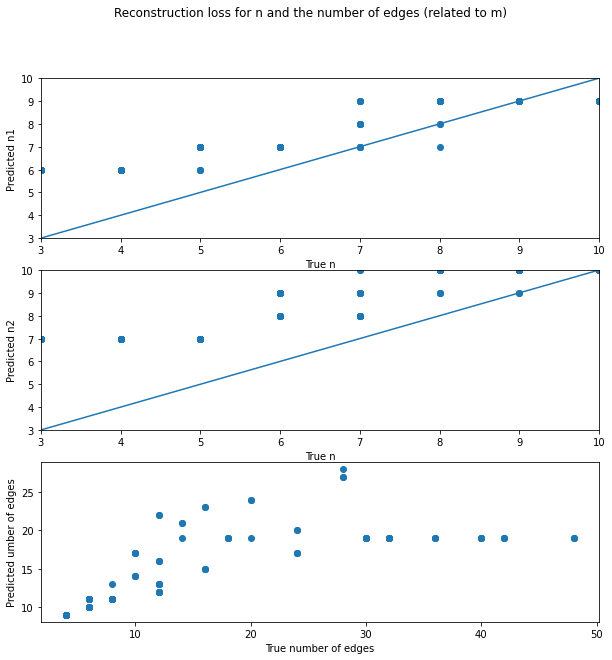

In [18]:
fig, axs = plt.subplots(3, figsize=(10, 10))

fig.suptitle('Reconstruction loss for n and the number of edges (related to m)')

axs[0].set_xlim((N_MIN, N_MAX))
axs[0].set_ylim((N_MIN, N_MAX))
axs[0].scatter(result_matrix_n[2, :], result_matrix_n[0,:])
x = range(N_MIN, N_MAX+1, 1)
axs[0].plot(x, x)
axs[0].set_xlabel('True n')
axs[0].set_ylabel('Predicted n1')

print()
print('Because the reconstructed adjacency matrix might not be symmetric (even if the')
print('reconstruction loss is ensuring for this), then we can recover two possible')
print('values for the reconstructed n (the number of non-empty rows n1 or the number of')
print('non-empty columns n2)')
print()

mse = mean_squared_error(result_matrix_n[2, :], result_matrix_n[0,:])
print('mean squared n for reconstructed n1: ' + str(mse))

axs[1].set_xlim((N_MIN, N_MAX))
axs[1].set_ylim((N_MIN, N_MAX))
axs[1].scatter(result_matrix_n[2, :], result_matrix_n[1,:])
x = range(N_MIN, N_MAX+1, 1)
axs[1].plot(x, x)
axs[1].set_xlabel('True n')
axs[1].set_ylabel('Predicted n2')

mse = mean_squared_error(result_matrix_n[2, :], result_matrix_n[1,:])
print('mean squared n for reconstructed n2: ' + str(mse))

axs[2].scatter(result_matrix_nb_edges[1, :], result_matrix_nb_edges[0,:])
axs[2].set_xlabel('True number of edges')
axs[2].set_ylabel('Predicted umber of edges')

mse = mean_squared_error(result_matrix_nb_edges[1, :], result_matrix_nb_edges[0,:])
print('mean squared n for reconstructed number of edges: ' + str(mse))

plt.show()

## Experiment 2: Latent Space

### Experiment parameters

In [19]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 200

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 150
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2 # Normalization constant for the KL divergence used in the reconstruction loss

## Seed random number generator
SEED = 123
np.random.seed(123)
tf.random.set_seed(123)
seed(SEED)

### Compute

In [20]:
result_matrix_latent = np.zeros((LATENT_SPACE_SIZE, NB_TRAINING))
result_matrix_parameters = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))
       
# Generate train data
A_train, X_train, Y_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

# Train
model = fit_ae(A_train, X_train)

# Retrieve latent space values
graph_conv_filters = preprocess_adj_tensor_with_identity(A_train, SYM_NORM)
train = [X_train, graph_conv_filters]

latent_space_layer = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)
latent_pred = latent_space_layer.predict(train)

# Store result
result_matrix_latent = latent_pred.T
result_matrix_parameters = Y_train.T

In [21]:
# Store latent and paramaters values into CSV files, this is later used 
# to compute the Mutual Information Gap (MIG) with an other python script. 

import pandas as pd 
pd.DataFrame(result_matrix_latent).to_csv('ae_latent_scenario_3.csv')
pd.DataFrame(result_matrix_parameters).to_csv('ae_params_scenario_3.csv')

### Display

/home/tristan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tristan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



Covariance matrix between the latent space and the generative parameters.
The rows correspond to Z0, Z1, and Z3. The columns correspond to n, m and alpha respectively.
The NaN can be interpreted as 0 correlation.

[[-0.9176946  -0.51862442         nan]
 [ 0.38735697  0.26040438         nan]
 [ 0.39005757  0.26320596         nan]]


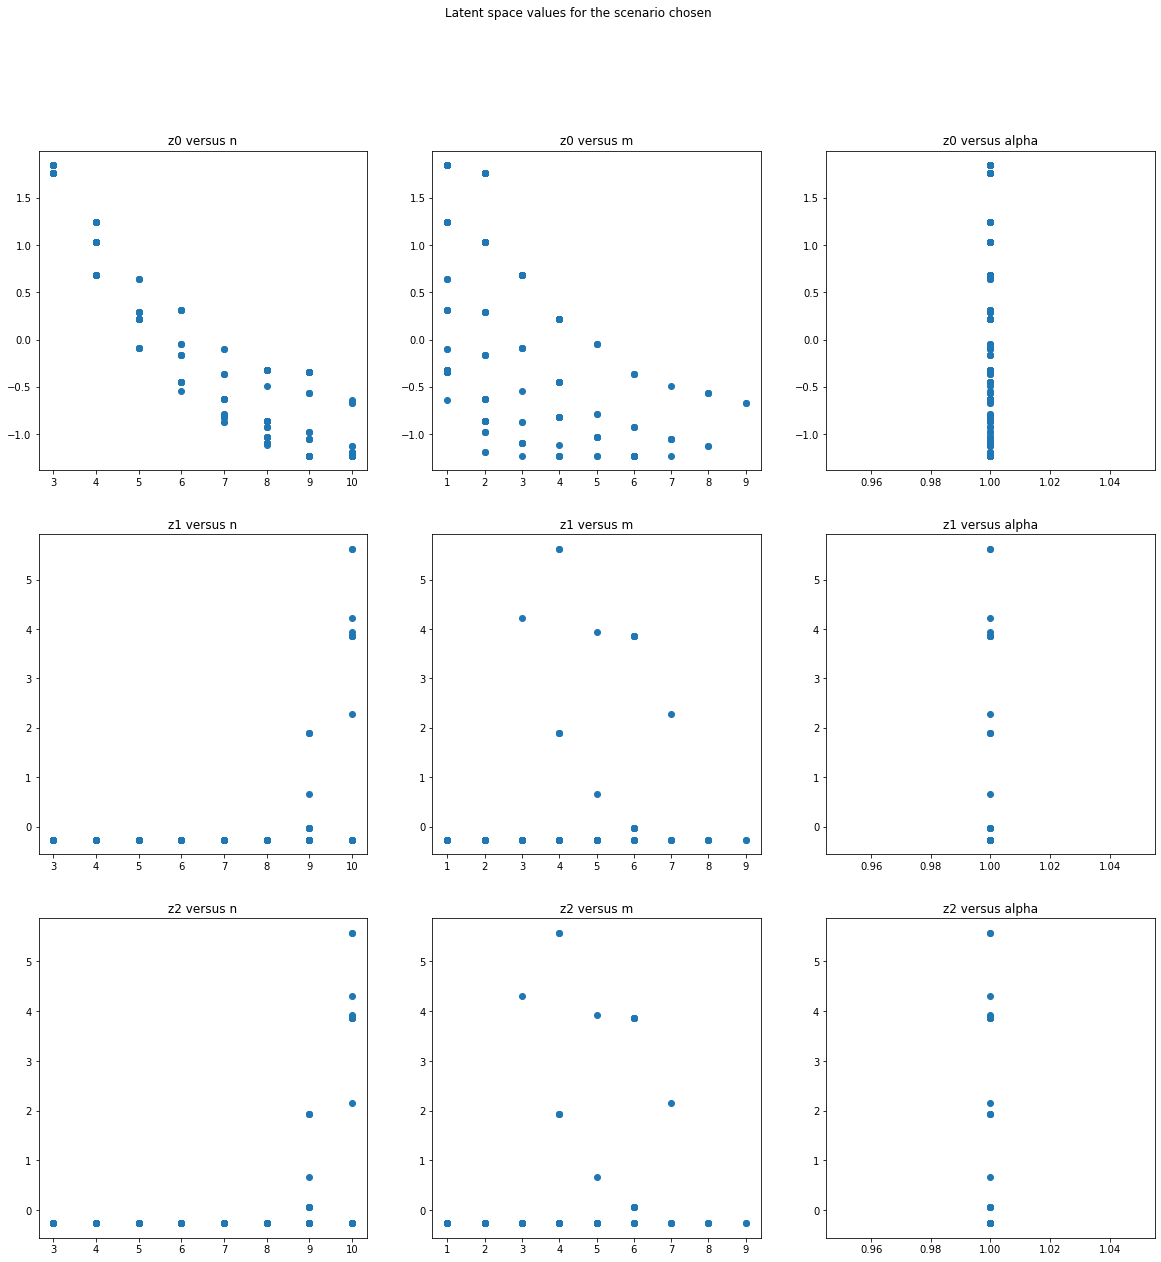

In [22]:
fig, axs = plt.subplots(LATENT_SPACE_SIZE, PARAMETER_SPACE_SIZE, figsize=(20, 20))
covariance_matrix = np.zeros((LATENT_SPACE_SIZE, PARAMETER_SPACE_SIZE))

fig.suptitle('Latent space values for the scenario chosen')
for z in range(LATENT_SPACE_SIZE):
    for p in range(PARAMETER_SPACE_SIZE):
        x = result_matrix_parameters[p, :]
        y = result_matrix_latent[z, :]
        if np.std(y) != 0:
            y = (y - np.mean(y)) / np.std(y)
        
        covariance_matrix[z, p] = np.corrcoef(y, x)[0, 1]

        axs[z, p].scatter(x, y)

        if p == 0:
            axs[z, p].set_title('z' + str(z) + ' versus n')
        if p == 1:
            axs[z, p].set_title('z' + str(z) + ' versus m')
        if p == 2:
            axs[z, p].set_title('z' + str(z) + ' versus alpha')

print()
print('Covariance matrix between the latent space and the generative parameters.')
print('The rows correspond to Z0, Z1, and Z3. The columns correspond to n, m and alpha respectively.')
print('The NaN can be interpreted as 0 correlation.')
print()
print(covariance_matrix)

## Experiment 3: Predicted Parameters

### Experiment parameters

In [23]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 200

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 150
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2 # Normalization constant for the KL divergence used in the reconstruction loss

## For H function
NB_EPOCHS_H = 100
BATCH_SIZE_H = 1

## Seed random number generator
SEED = 567
np.random.seed(567)
tf.random.set_seed(567)
seed(SEED)

### Compute

In [24]:
result_matrix_param_pred = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))
result_matrix_param_true = np.zeros((PARAMETER_SPACE_SIZE, NB_TRAINING))

# Generate train data
A_train, X_train, Y_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

# Train
model = fit_ae(A_train, X_train)

# Retrieve latent space values
graph_conv_filters = preprocess_adj_tensor_with_identity(A_train, SYM_NORM)
train = [X_train, graph_conv_filters]

latent_space_layer = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)
latent_pred = latent_space_layer.predict(train)

# Train H and predict 
h_X_train = latent_pred
h_y_train = Y_train
h_model = fit_h(h_X_train, h_y_train)
h_prediction = predict_h(h_model, h_X_train)

# Store result
result_matrix_param_pred = h_prediction.T
result_matrix_param_true = Y_train.T

### Display

Result for n: (mse) 0.915 (r2) 0.8074454428754814
Result for m: (mse) 2.635 (r2) 0.3366730440036251
Result for alpha: (mse) 0.0 (r2) 1.0

Covariance vector between the true parameters and the predicted parameters
for n, m and alpha respectively.

[0.90445539 0.58342542        nan]


/home/tristan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


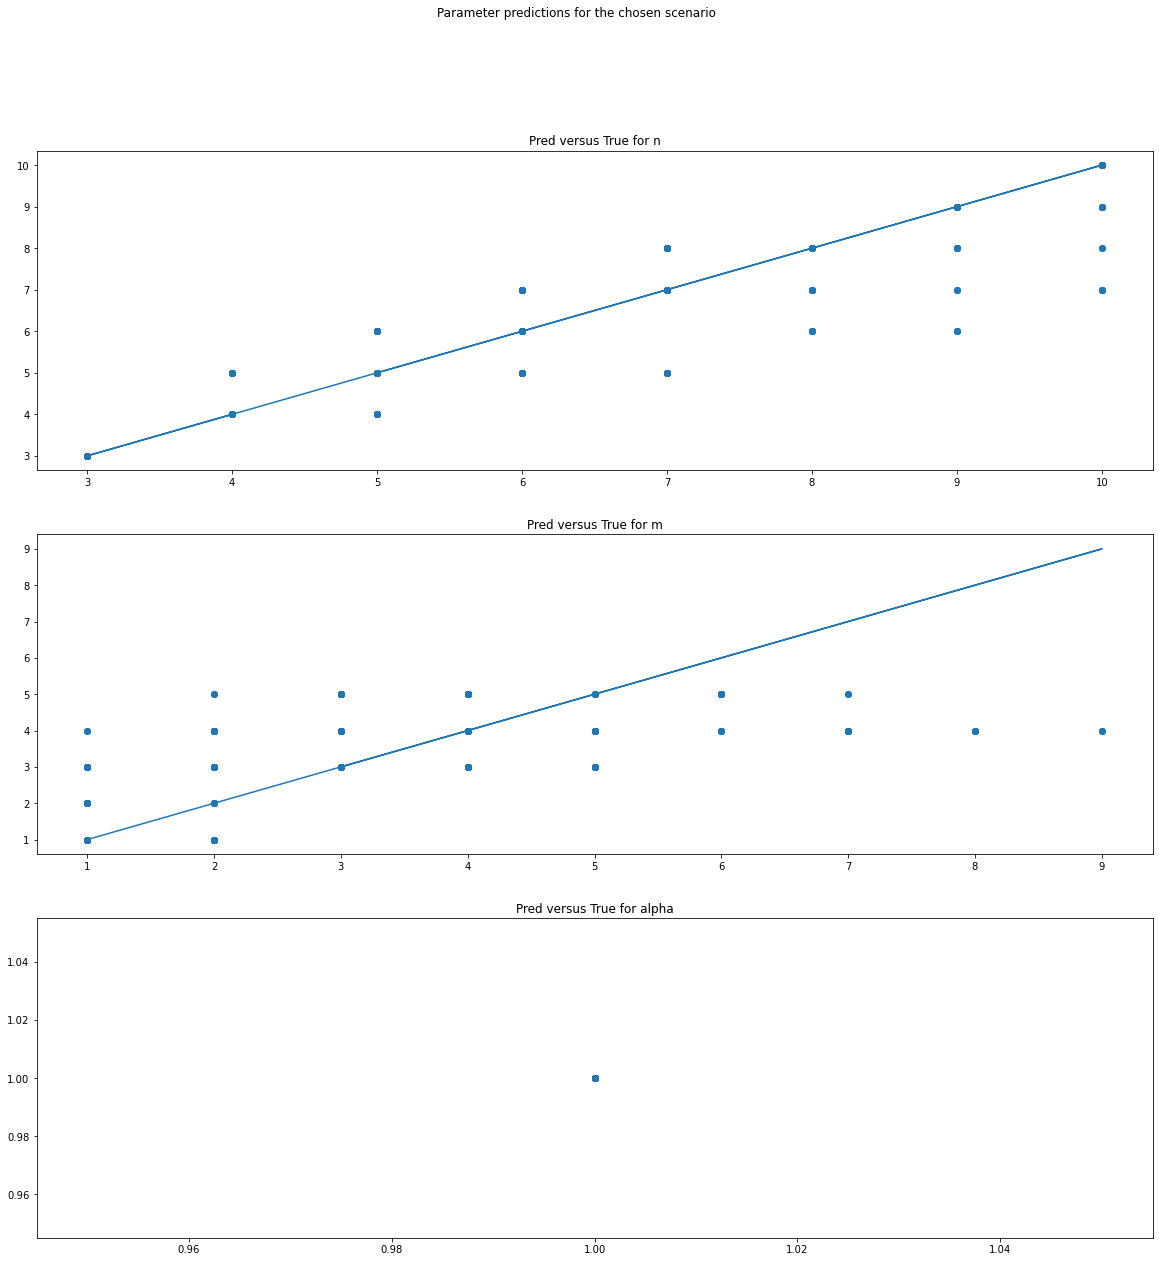

In [25]:
fig, axs = plt.subplots(PARAMETER_SPACE_SIZE, figsize=(20, 20))
covariance_vector = np.zeros((PARAMETER_SPACE_SIZE))

fig.suptitle('Parameter predictions for the chosen scenario')
for p in range(PARAMETER_SPACE_SIZE):

    x = result_matrix_param_true[p, :]
    y = result_matrix_param_pred[p, :]
    mse = mean_squared_error(x, y)
    r_squared = r2_score(x, y)
    
    covariance_vector[p] = np.corrcoef(y, x)[0, 1]

    axs[p].scatter(x, y)
    axs[p].plot(x, x)

    if p == 0:
        axs[p].set_title('Pred versus True for n')
        print('Result for n: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
    if p == 1:
        axs[p].set_title('Pred versus True for m')
        print('Result for m: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
    if p == 2:
        axs[p].set_title('Pred versus True for alpha')
        print('Result for alpha: ' +
              '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))

print()
print('Covariance vector between the true parameters and the predicted parameters')
print('for n, m and alpha respectively.')
print()
print(covariance_vector)

## Experiment 4: Loss function

### Experiment parameters

In [26]:
## Tested scenario
TESTED_SCENARIO = 3

## Number of training graphs
NB_TRAINING = 200

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 10 # Max number of nodes in the generated graphs
N_MIN = 3 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 150
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2 # Normalization constant for the KL divergence used in the reconstruction loss

## For H function
NB_EPOCHS_H = 100
BATCH_SIZE_H = 1

## Seed random number generator
SEED = 567
np.random.seed(567)
tf.random.set_seed(567)
seed(SEED)

### Compute

In [27]:
result_matrix_param_pred = np.zeros((2, PARAMETER_SPACE_SIZE, NB_TRAINING))
result_matrix_param_true = np.zeros((2, PARAMETER_SPACE_SIZE, NB_TRAINING))

for i in range(2):
    
    # Generate train data
    A_train, X_train, Y_train = \
        generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = TESTED_SCENARIO) 
    A_train, X_train, Y_train = format_data(A_train, X_train, Y_train)

    # Train
    if i == 0:
        model = fit_ae(A_train, X_train, with_sequence_loss=True)
    else:
        model = fit_ae(A_train, X_train, with_sequence_loss=False)
    
    # Retrieve latent space values
    graph_conv_filters = preprocess_adj_tensor_with_identity(A_train, SYM_NORM)
    train = [X_train, graph_conv_filters]

    latent_space_layer = Model(inputs=model.input, outputs=model.get_layer('latent_space').output)
    latent_pred = latent_space_layer.predict(train)

    # Train H and predict 
    h_X_train = latent_pred
    h_y_train = Y_train
    h_model = fit_h(h_X_train, h_y_train)
    h_prediction = predict_h(h_model, h_X_train)

    # Store result
    result_matrix_param_pred[i, :, :] = h_prediction.T
    result_matrix_param_true[i, :, :] = Y_train.T

### Display


By using a sequencial loss:
Result for n: (mse) 0.915 (r2) 0.8074454428754814
Result for m: (mse) 2.635 (r2) 0.3366730440036251
Result for alpha: (mse) 0.0 (r2) 1.0

By using a non-sequencial loss:
Result for n: (mse) 4.98 (r2) -0.00654862963861258
Result for m: (mse) 3.895 (r2) -0.016977917610428328
Result for alpha: (mse) 0.0 (r2) 1.0


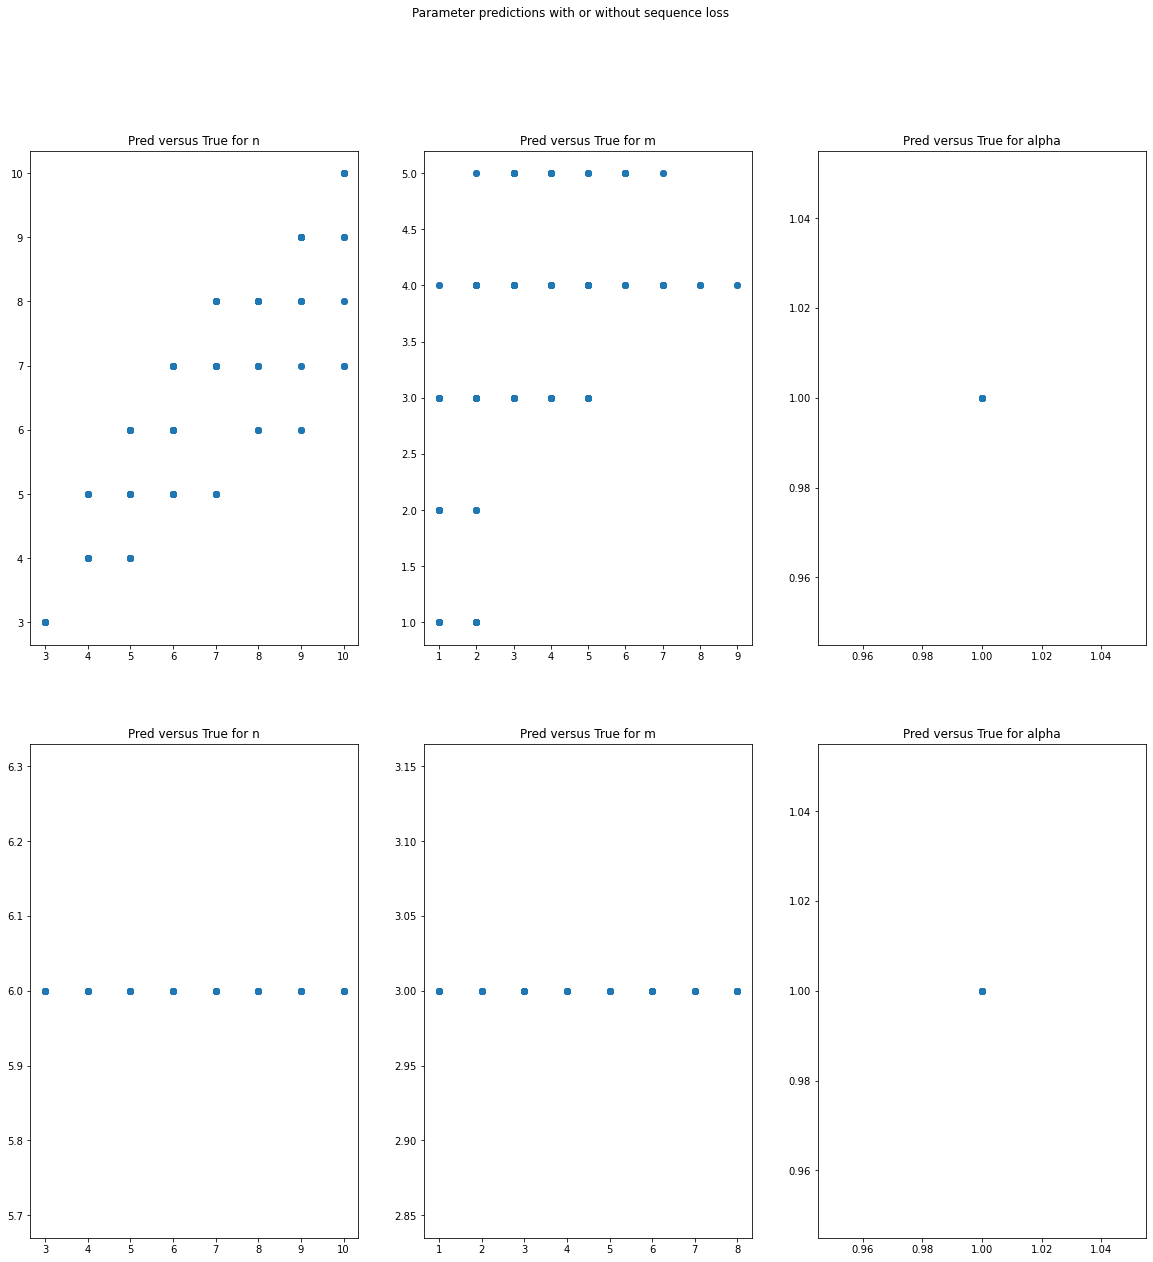

In [28]:
fig, axs = plt.subplots(2, PARAMETER_SPACE_SIZE, figsize=(20, 20))

fig.suptitle('Parameter predictions with or without sequence loss')
for i in range(2):
    
    if i == 0:
        print()
        print('By using a sequencial loss:')
    if i == 1:
        print()
        print('By using a non-sequencial loss:')
        
    for p in range(PARAMETER_SPACE_SIZE):
        
        x = result_matrix_param_true[i, p, :]
        y = result_matrix_param_pred[i, p, :]
        mse = mean_squared_error(x, y)
        r_squared = r2_score(x, y)
        
        axs[i, p].scatter(x, y)
                
        if p == 0:
            axs[i, p].set_title('Pred versus True for n')
            print('Result for n: ' +
                  '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
        if p == 1:
            axs[i, p].set_title('Pred versus True for m')
            print('Result for m: ' +
                  '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))
        if p == 2:
            axs[i, p].set_title('Pred versus True for alpha')
            print('Result for alpha: ' +
                  '(mse) ' + str(mse) + ' (r2) ' + str(r_squared))

# Some additional visualizations

### Visualization parameters

In [29]:
## Scenario to be tested
SCENARIO_TYPE = 2

## Number of training graphs
NB_TRAINING = 30

## Modeling assumptions
PARAMETER_SPACE_SIZE = 3 # m, n and alpha
LATENT_SPACE_SIZE = 3 # Size of the latent space in AE LSTM
N_MAX = 5 # Max number of nodes in the generated graphs
N_MIN = 5 # Min number of nodes in the generated graphs (must be at least 2)

## For AE LSTM
SYM_NORM = True # Use symmetric norm for adjacency matrix or not
NB_EPOCHS_AE = 200
BATCH_SIZE_AE = 1
KL_WEIGHT = 10e2 # Normalization constant for the KL divergence used in the reconstruction loss

## Seed random number generator
SEED = 345
np.random.seed(345)
tf.random.set_seed(345)
seed(SEED)

## Training AE LSTM

### Generate training data

In [30]:
# Generate train data
adjacency_matrices_train, feature_matrices_train, parameter_vectors_train = \
    generate_multi_barabasi_graphs(nb_graphs = NB_TRAINING, scenario_type = SCENARIO_TYPE)

### Train network

In [31]:
# Load Train data
A_train, X_train, Y_train = \
    format_data(adjacency_matrices_train, feature_matrices_train, parameter_vectors_train)

# Train
model = fit_ae(A_train, X_train)

## Visualize the reconstruction graphs

In [32]:
# Pick some trinaing graph
graph_id = 2

## Example sample original graph

In [33]:
original_adjacency = A_train[graph_id,:,:]
original_adjacency

array([[0., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Example reconstruction graph sequence

In [34]:
# Predictions on train
graph_conv_filters = preprocess_adj_tensor_with_identity(A_train[graph_id:graph_id+1,:,:], SYM_NORM)
result_adjacency_matrices = np.rint(model.predict([X_train[graph_id:graph_id+1,:, :], graph_conv_filters])[0])
result_adjacency_matrices = result_adjacency_matrices.reshape((N_MAX, N_MAX, N_MAX))
result_adjacency_matrices

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 1.],
        [0., 0., 0., 1., 0.]]], dtype=float32)

## Example plotting reconstruction graph sequence

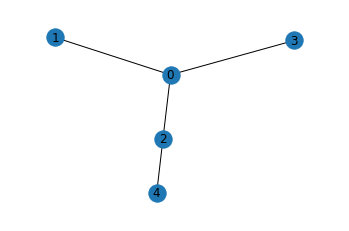

In [35]:
# Plot the original graph

G = nx.from_numpy_matrix(remove_single_nodes(original_adjacency))
nx.draw_networkx(G)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

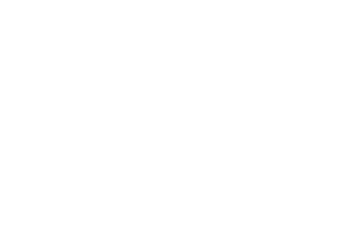

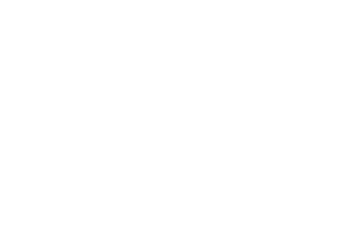

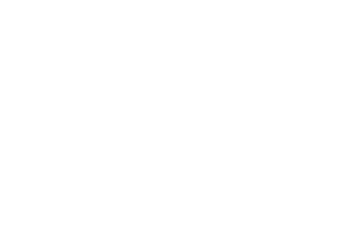

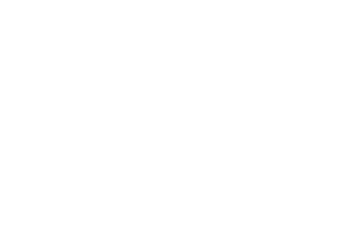

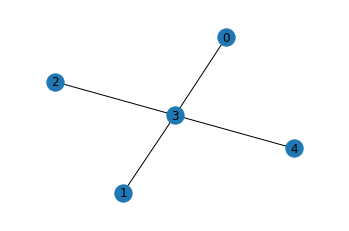

In [36]:
# Plot the resulting graphs

for ajacency_matrix in result_adjacency_matrices:
    G = nx.from_numpy_matrix(remove_single_nodes(ajacency_matrix))
    nx.draw_networkx(G)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.20)
    plt.axis("off")
    plt.show()